In [10]:
import itertools
import json
import os
import random
from pathlib import Path

import cv2
import numpy as np
import torch
from shapely import Polygon
from torch.utils.data import DataLoader
from tqdm import tqdm

from datasets.SlideSeperatedImageDataset import SlideSeperatedImageDataset
from labelers.GroundTruthLabeler import GroundTruthLabeler
from models.resnet import Resnet18BinaryClassifier, Resnet101BinaryClassifier
from utils import divide, bbox_to_points, rgb_to_bgr, downscale_points, absolute_points_to_relative, \
    filter_points_within_bbox, \
    is_not_mostly_blank
from utils import show_cv2_image

In [11]:
slides_root_dir = "data/whole-slides/gut"
labels_root_dir = "data/labels"
candidates_dataset_dir = "output/candidates"
model_output_dir = "output/models"
PretrainedModelClass = Resnet101BinaryClassifier
pretrained_model_name = PretrainedModelClass.get_pretrained_model_name()
pretrained_output_size = PretrainedModelClass.pretrained_output_size
print(f"{pretrained_model_name}: {pretrained_output_size} features")

Resnet101: 2048 features


In [12]:
ground_truth_labeler = GroundTruthLabeler(f"{labels_root_dir}/slide-annotations/all.json",
                                          f"{labels_root_dir}/patch-classifications.csv")
with open(f"{model_output_dir}/data-split.json", 'r') as f:
    backup = json.load(f)
slides_df = ground_truth_labeler.positive_regions_summary
train_slides, test_slides = set(backup["train_slides"]), set(backup["test_slides"])
if train_slides.union(test_slides) != set(slides_df["slide_name"]) or len(train_slides.intersection(test_slides)) > 0:
    raise ValueError("Invalid train test split")
train_slides = slides_df[slides_df['slide_name'].isin(train_slides)]
test_slides = slides_df[slides_df['slide_name'].isin(test_slides)]
model = PretrainedModelClass(model=torch.load(f"{model_output_dir}/{pretrained_model_name}.pickle"))
print("Test slides")
test_slides

Test slides


slide_name  n_gt_positive_regions  category
0      593437                     94         3
8      593435                    109         4
12     593436                    170         4
13     593453                     19         2
15     522021                      3         1
16     593434                     27         2
20     593446                     15         1

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
model = model.to(device)
batch_size = 256
test_dataset = SlideSeperatedImageDataset(candidates_dataset_dir, set(test_slides["slide_name"]), with_index=True)
# test_dataset = reduce_dataset(test_dataset, discard_ratio=0.99)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False, )

print(f"Candidates: {len(test_dataset):,}")

Device: cuda:0
Candidates: 14,346


In [14]:

model.eval()
indexes = []
probs = []
with torch.no_grad():
    for i, (x_test, y_test, index) in enumerate(tqdm(iter(test_loader), desc=f"Testing")):
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        test_logits = model.forward(x_test)
        test_loss = model.loss_function(test_logits, y_test)
        # test_preds = model.predict(test_logits)
        indexes.append(index)
        probs.append(test_logits.squeeze())
indexes = torch.cat(indexes).to("cpu")
probs = torch.cat(probs).to("cpu")


Testing: 100%|██████████| 57/57 [00:20<00:00,  2.72it/s]


In [15]:
threshold = 0.3
predictions = probs > threshold
predicted_positives = indexes[predictions == 1]
predicted_positive_bboxes_by_slide = {}
while not isinstance(test_dataset, SlideSeperatedImageDataset):
    test_dataset = test_dataset.dataset

for item_index in predicted_positives:
    file_path = test_dataset.get_item_file_path(item_index)
    file_name = Path(file_path).stem
    slide, x_min, y_min, width, height = file_name.split("_")
    x_min, y_min, width, height = int(x_min), int(y_min), int(width), int(height)
    if not slide in predicted_positive_bboxes_by_slide:
        predicted_positive_bboxes_by_slide[slide] = []
    predicted_positive_bboxes_by_slide[slide].append((x_min, y_min, width, height))

In [16]:
import json

with open("temp.json", "w") as f:
    json.dump(predicted_positive_bboxes_by_slide, f)

In [19]:



def calculate_iou(poly, bbox):
    intersection = poly.buffer(0).intersection(bbox).area
    union = poly.buffer(0).union(bbox).area
    return intersection / union if union > 0 else 0


def calculate_iogt(poly, bbox):
    intersection = poly.buffer(0).intersection(bbox).area
    return intersection / poly.area if poly.area > 0 else 0


def calculate_iopd(poly, bbox):
    intersection = poly.buffer(0).intersection(bbox).area
    return intersection / bbox.area if bbox.area > 0 else 0


def calculate_metrics(confusion_matrix):
    tp, fp, fn = confusion_matrix["TP"], confusion_matrix["FP"], confusion_matrix["FN"]
    precision = divide(tp, (tp + fp))
    recall = divide(tp, (tp + fn))
    f1 = divide(2 * precision * recall, (precision + recall))
    return precision, recall, f1


def is_matched(gt, pred, i_threshold=0.5):
    iou = calculate_iou(gt, pred)
    igt = calculate_iogt(gt, pred)
    ipd = calculate_iopd(gt, pred)
    return  igt > i_threshold  #or iou > i_threshold #or ipd > i_threshold


def calculate_iou_confusion_matrix(ground_truth_polygons, predicted_bboxes, i_threshold=0.25):
    gt_polys = [Polygon(pts).buffer(0) for pts in ground_truth_polygons]
    pred_polys = [Polygon([(x, y), (x + w, y), (x + w, y + h), (x, y + h)]).buffer(0) for x, y, w, h in
                  predicted_bboxes]
    matched_gt = set()
    matched_pred = set()
    for i, gt in enumerate(gt_polys):
        for j, pred in enumerate(pred_polys):
            if is_matched(gt, pred, i_threshold):
                matched_gt.add(i)
                matched_pred.add(j)

    TP = len(matched_gt)
    FP = len(pred_polys) - len(matched_pred)
    FN = len(gt_polys) - len(matched_gt)

    return {
        "TP": TP,
        "FP": FP,
        "FN": FN
    }


total_confusion_matrix = {
    "TP": 0,
    "FP": 0,
    "FN": 0
}
for slide_name in test_slides.slide_name:
    ground_truth_positive_regions = ground_truth_labeler.get_positive_regions(slide_name)
    predicted_positive_bboxes = predicted_positive_bboxes_by_slide.get(slide_name, [])
    confusion_matrix = calculate_iou_confusion_matrix(ground_truth_positive_regions, predicted_positive_bboxes)
    tp, fp, fn = confusion_matrix["TP"], confusion_matrix["FP"], confusion_matrix["FN"]
    precision, recall, f1 = calculate_metrics(confusion_matrix)

    total_confusion_matrix["TP"] += tp
    total_confusion_matrix["FP"] += fp
    total_confusion_matrix["FN"] += fn

    n_ground_truth_pos = len(ground_truth_positive_regions)
    n_cv_candidate_pos = test_dataset.slide_to_dataset[slide_name].labels.sum().item()

    print(
        f"{slide_name}: {n_ground_truth_pos:03d} ground truth positives, {n_cv_candidate_pos:03d} positive candidate patches, precision: {precision:.6f}, recall: {recall:.6f}, f1: {f1:.6f}")
total_precision, total_recall, total_f1 = calculate_metrics(total_confusion_matrix)
print()
print(f"Overall: precision: {total_precision:.6f}, recall: {total_recall:.6f}, f1: {total_f1:.6f}")


593437: 094 ground truth positives, 065 positive candidate patches, precision: 0.477612, recall: 0.340426, f1: 0.397516
593435: 109 ground truth positives, 072 positive candidate patches, precision: 0.555556, recall: 0.504587, f1: 0.528846
593436: 170 ground truth positives, 116 positive candidate patches, precision: 0.679012, recall: 0.647059, f1: 0.662651
593453: 019 ground truth positives, 010 positive candidate patches, precision: 0.103448, recall: 0.157895, f1: 0.125000
522021: 003 ground truth positives, 002 positive candidate patches, precision: 0.011364, recall: 0.333333, f1: 0.021978
593434: 027 ground truth positives, 014 positive candidate patches, precision: 0.269231, recall: 0.518519, f1: 0.354430
593446: 015 ground truth positives, 008 positive candidate patches, precision: 0.094595, recall: 0.466667, f1: 0.157303

Overall: precision: 0.388792, recall: 0.508009, f1: 0.440476


593436


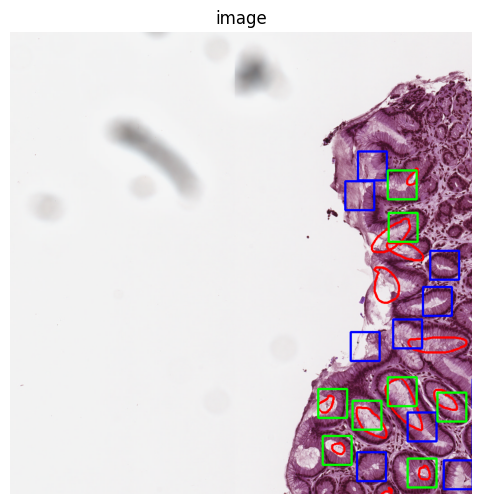

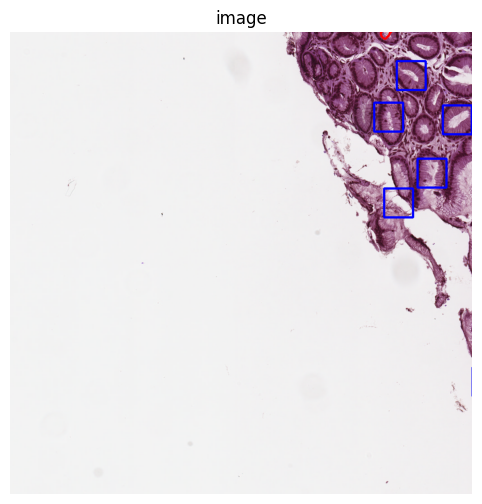

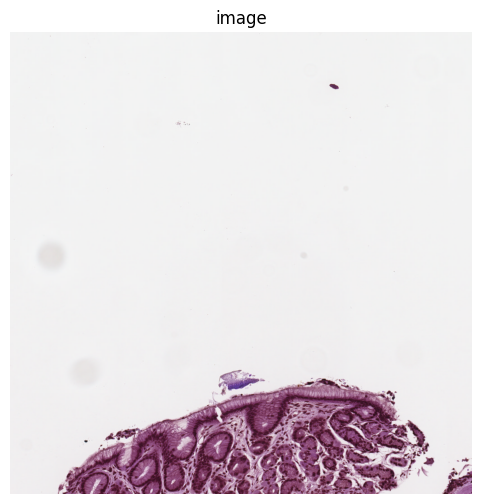

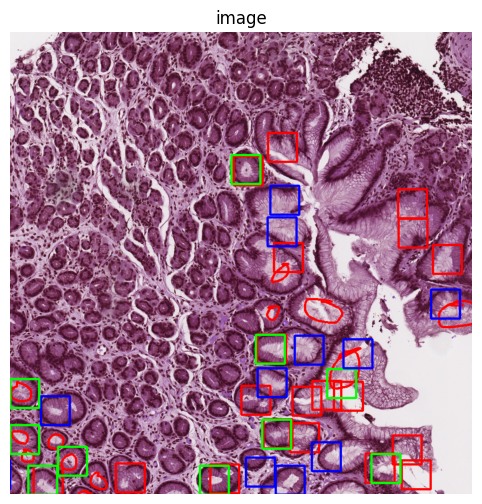

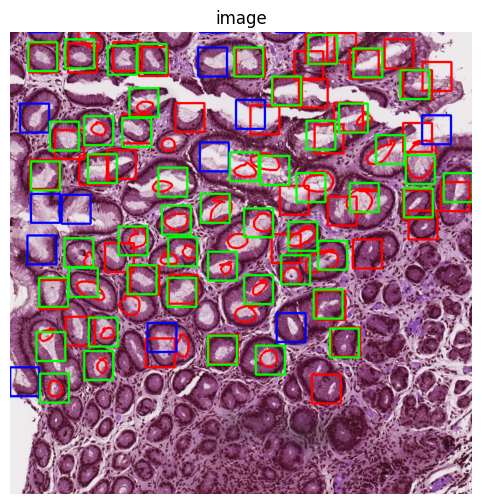

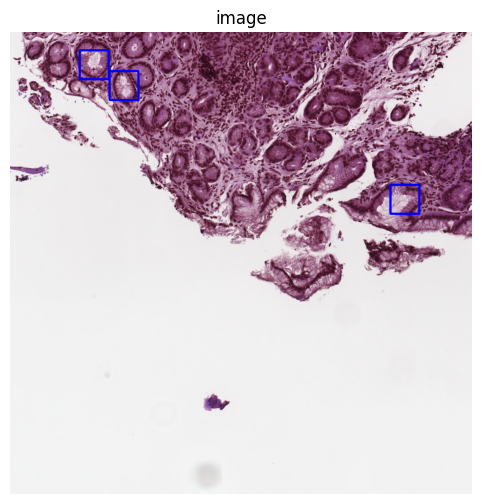

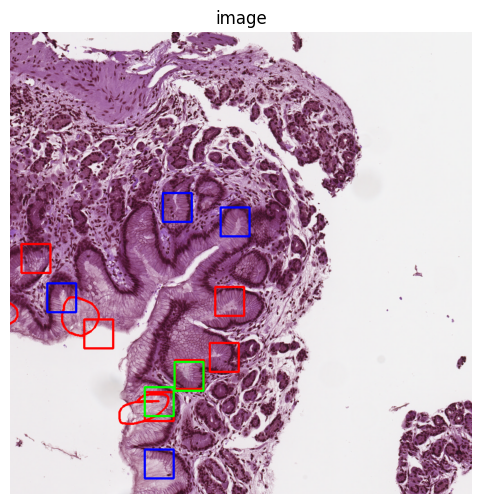

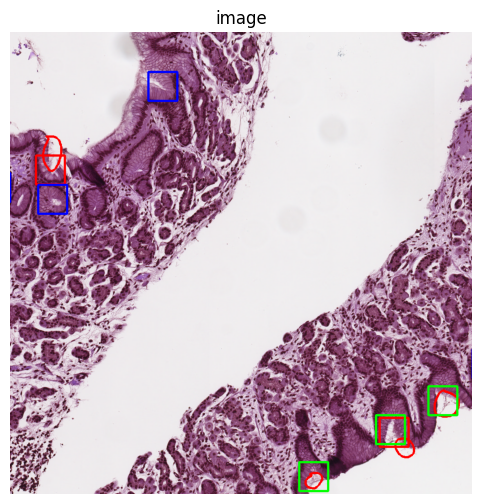

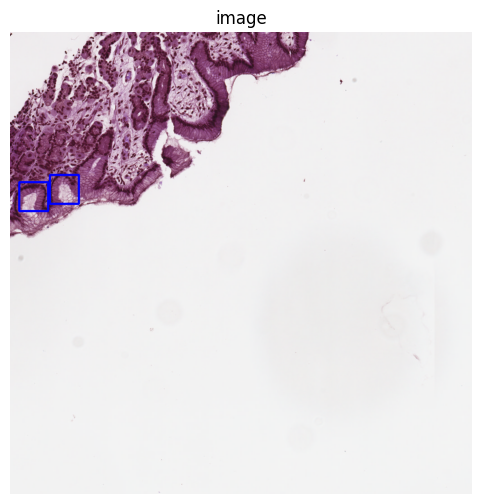

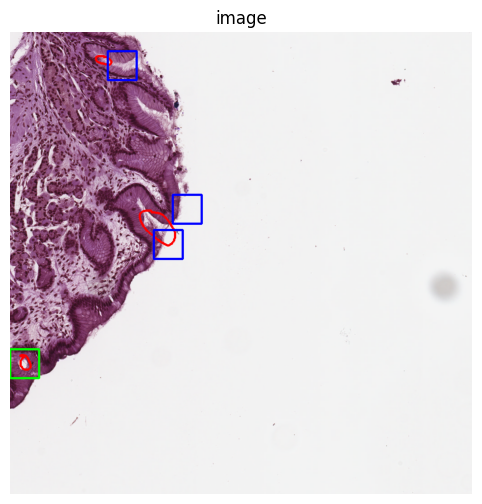

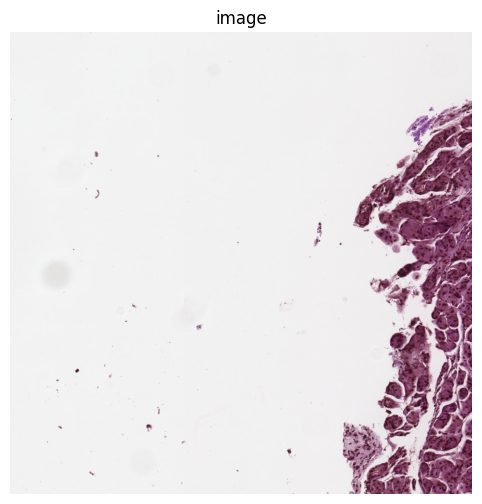

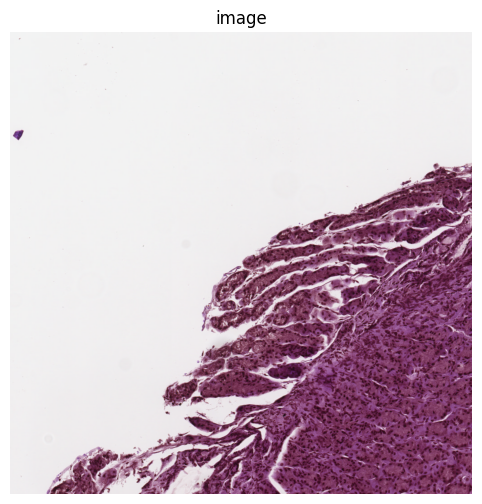

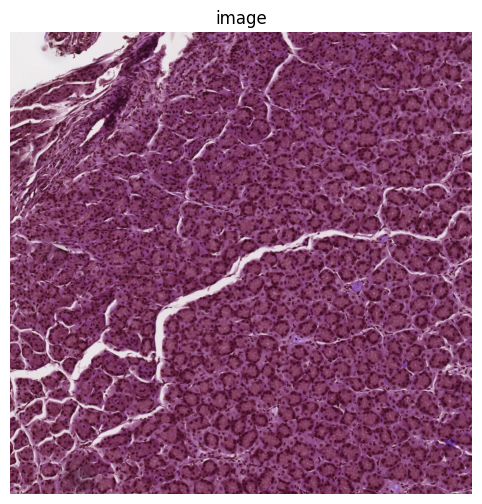

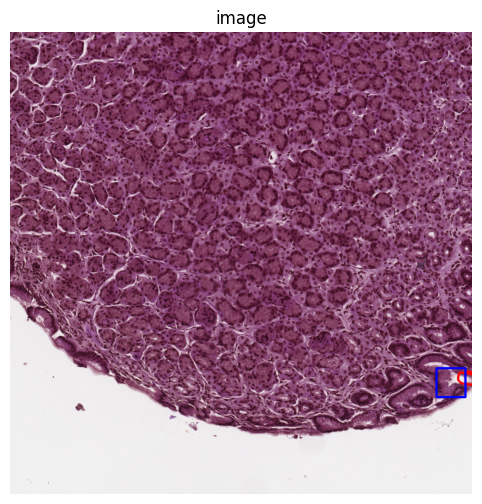

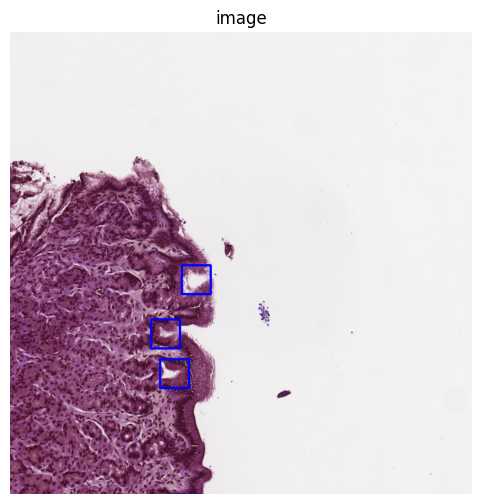

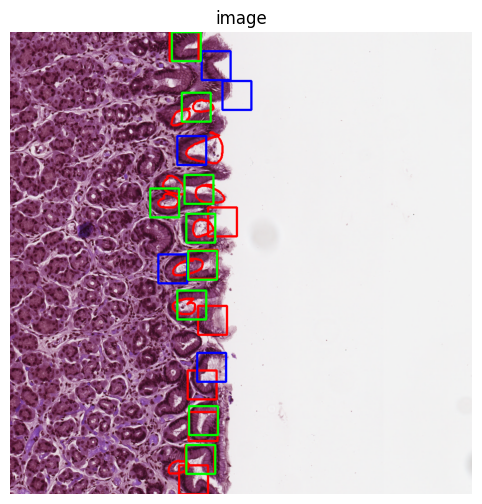

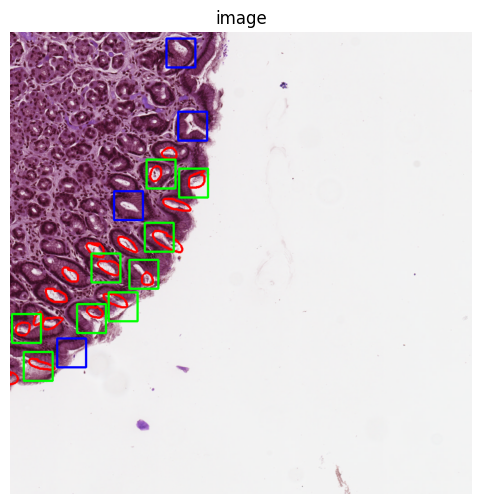

In [18]:
if hasattr(os, 'add_dll_directory'):
    # Windows
    OPENSLIDE_PATH = os.path.join(os.path.abspath(os.getcwd()), "libs/openslide-bin-4.0.0.3-windows-x64/bin")
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide


def draw_gt_and_pred(slide_name, cell, cell_bbox, thickness=2):
    gt_in_cell = ground_truth_labeler.get_positive_regions(slide_name, cell_bbox)
    for ground_truth_region in gt_in_cell:
        ground_truth_points = absolute_points_to_relative(ground_truth_region, cell_bbox)
        ground_truth_points = downscale_points(ground_truth_points, level_downsample)
        cv2.polylines(cell, [np.array(ground_truth_points).reshape((-1, 1, 2))], isClosed=True,
                      color=rgb_to_bgr((255, 0, 0)), thickness=thickness)
    predicted_positive_bboxes = predicted_positive_bboxes_by_slide.get(preview_slide_name, [])

    for pred_bbox in predicted_positive_bboxes:
        pred_points = bbox_to_points(pred_bbox)
        is_correct = any([is_matched(Polygon(gt), Polygon(pred_points)) for gt in gt_in_cell])
        pred_points = filter_points_within_bbox(pred_points, cell_bbox)
        if len(pred_points) == 0:
            continue
        pred_points = absolute_points_to_relative(pred_points, cell_bbox)
        pred_points = downscale_points(pred_points, level_downsample)
        cv2.polylines(cell, [np.array(pred_points).reshape((-1, 1, 2))], isClosed=True,
                      color=rgb_to_bgr((0, 255, 0) if is_correct else (0, 0, 255)), thickness=thickness)
    return cell


preview_slide_name = random.choice(list(test_slides.slide_name))
print(preview_slide_name)
preview_level = 1
preview_cell_size = 4096
slide = openslide.OpenSlide(f"{slides_root_dir}/{preview_slide_name}.svs")
level_downsample = slide.level_downsamples[preview_level]
ds_cell_size = int(preview_cell_size / level_downsample)
full_slide_width, full_slide_height = slide.level_dimensions[0]

preview_bboxes = [(x, y, preview_cell_size, preview_cell_size) for x, y in
                  itertools.product(range(0, full_slide_width, preview_cell_size),
                                    range(0, full_slide_height, preview_cell_size))]

titles = []

for i in range(len(preview_bboxes)):
    x, y, _, _ = preview_bboxes[i]
    preview_region = np.array(slide.read_region((x, y), preview_level, (ds_cell_size, ds_cell_size)).convert("RGBA"))
    if not is_not_mostly_blank(preview_region):
        continue
    preview_region = draw_gt_and_pred(preview_slide_name, preview_region, preview_bboxes[i], thickness=4)
    show_cv2_image(preview_region)
slide.close()
